In [1]:
#再變數後面按快捷鍵tab,有屬性或欄位提示
import math
import cv2
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from itertools import groupby
from scipy.io import loadmat

'''
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import np_utils
from keras import optimizers
from keras import regularizers
from keras.backend.tensorflow_backend import set_session

#跑GPU版本的tensorflow時可能會因為獨顯內存不夠而跑不起來,比如說同時開了遊戲或TeamView等,所以以下code是先分配好獨顯內存避免不夠用
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 

'''
np.random.seed(1)

In [2]:
# 图片到x轴或y轴的投影，如果有数据（黑色像素点）值为1，否则为0
def get_projection_x(_image): # axis = 0: x轴, axis = 1: y轴
    # 初始化投影标记list
    p_x = [0 for _ in range(_image.size[0])]
    width, height = _image.size
    
    for x in range(width):
        for y in range(height):
            if _image.getpixel((x, y)) == 255:
                p_x[x] = 1
                break
    return p_x

In [3]:
# 获取切割后的x轴坐标点，返回值为[初始位置，长度]的列表
def get_split_seq(projection_x):
    split_seq = []
    start_x = 0
    length = 0
    for pos_x, val in enumerate(projection_x):
        if val == 0 and length == 0:
            continue
        elif val == 0 and length != 0:
            split_seq.append([start_x, length])
            length = 0
        elif val == 1:
            if length == 0:
                start_x = pos_x
            length += 1
        else:
            raise Exception('generating split sequence occurs error')
    # 循环结束时如果length不为0，说明还有一部分需要append
    if length != 0:
        split_seq.append([start_x, length])
    return split_seq

In [4]:
def is_black(rgb):
    """
    : param rgb: tuple (r, g, b) 
    """
    return True if rgb == 255 else False

In [5]:
def get_start_x(hist_width):
    """
    根据待切割的图片的竖直投影统计hist_width，找到合适的滴水起始点
    hist_width的中间值，前后再取4个值，在这个范围内找最小值
    """
    mid = int(len(hist_width)/2)
    # 共9个值
    return mid - 4 + np.argmin(hist_width[mid - 4:mid + 5])

In [6]:
def get_end_route(image, start_x, height):
    """
    获得滴水的路径
    : param start_x: 滴水的起始x位置
    """
    left_limit = 0
    right_limit = image.size[0] - 1
    
    end_route = []
    #print("当前的start_x:", start_x)
    cur_p = (start_x, 0)
    last_p = cur_p
    end_route.append(cur_p)

    while cur_p[1] < (height - 1):
        sum_n = 0
        maxW = 0 # max Z_j*W_j
        nextX = cur_p[0]
        nextY = cur_p[1]

        if nextX+1 < left_limit or nextX+1 > right_limit:
            end_route.clear()
            end_route.append((start_x, 0))
            break
    
        for i in range(1, 6):
            curW = get_nearby_pixel_val(image, int(cur_p[0]), int(cur_p[1]), i) * (6 - i)
            sum_n += curW
            if maxW < curW:
                maxW = curW

        # 如果全黑，需要看惯性
        if sum_n == 0:
            maxW = 4

        # 如果全白，则默认垂直下落
        if sum_n == 15:
            maxW = 6

        if maxW == 1:
            nextX = cur_p[0] - 1
            nextY = cur_p[1]
        elif maxW == 2:
            nextX = cur_p[0] + 1
            nextY = cur_p[1]
        elif maxW == 3:
            nextX = cur_p[0] + 1
            nextY = cur_p[1] + 1
        elif maxW == 5:
            nextX = cur_p[0] - 1
            nextY = cur_p[1] + 1
        elif maxW == 6:
            nextX = cur_p[0]
            nextY = cur_p[1] + 1
        elif maxW == 4:
            if nextX > cur_p[0]: # 具有向右的惯性
                nextX = cur_p[0] + 1
                nextY = cur_p[1] + 1

            if nextX < cur_p[0]:
                nextX = cur_p[0]
                nextY = cur_p[1] + 1

            if sum_n == 0:
                nextX = cur_p[0]
                nextY = cur_p[1] + 1
        else:
            raise Exception("get a wrong maxW, pls check")

        # 如果出现重复运动
        if last_p[0] == nextX and last_p[1] == nextY:
            if nextX < cur_p[0]:
                maxW = 5
                nextX = cur_p[0] + 1
                nextY = cur_p[1] + 1
            else:
                maxW = 3
                nextX = cur_p[0] - 1
                nextY = cur_p[1] + 1

        last_p = cur_p

        if nextX > right_limit:
            nextX = right_limit
            nextY = cur_p[1] + 1

        if nextX < left_limit:
            nextX = left_limit
            nextY = cur_p[1] + 1

        cur_p = (nextX, nextY)
        #print(list(cur_p))
        end_route.append(cur_p)

        # 返回分割路径
    return end_route

In [7]:
def get_nearby_pixel_val(image, cx, cy, j):
    if j == 1:
        return 0 if is_black(image.getpixel((cx - 1, cy + 1))) else 1
    elif j == 2:
        return 0 if is_black(image.getpixel((cx, cy + 1))) else 1
    elif j == 3:
        return 0 if is_black(image.getpixel((cx + 1, cy + 1))) else 1
    elif j == 4:
        return 0 if is_black(image.getpixel((cx + 1, cy))) else 1
    elif j == 5:
        return 0 if is_black(image.getpixel((cx - 1, cy))) else 1
    else:
        raise Exception("what you request is out of nearby range")

In [8]:
def do_split(source_image, starts, filter_ends):
    """
    具体实行切割 
    : param starts: 每一行的起始点 tuple of list
    : param ends: 每一行的终止点
    """
    left = starts[0][0]
    #top = starts[0][1]
    right = filter_ends[0][0]
    #bottom = filter_ends[0][1]

    for i in range(len(starts)):
        left = min(starts[i][0], left)
        
    for i in range(len(filter_ends)):
        right = max(filter_ends[i][0], right)
        

    width = right - left + 1
    w, h = source_image.size
    height = h
    #height = bottom - top + 1
    '''
    image = Image.new('RGB', (width, height), 0)
    
    for i in range(height):
        start = starts[i]
        end = filter_ends[i]
        print(start, end)
        for x in range(start[0], end[0]+1):
            if is_black(source_image.getpixel((x, start[1]))):
                image.putpixel((x - left, start[1] - top), 0)
    '''
    s = np.array(source_image)
    image = np.array(s[:, left:right])
    
    return image

In [9]:
def drop_fall(image):
    """
    对粘连两个字符的图片进行drop fall算法分割
    """
    # 1. 竖直投影统计
    width, height = image.size
    #print("当前待切割图片的 width:" , width , "height:" , height)
    hist_width = [0]*width
    for x in range(width):
        for y in range(height):
            if is_black(image.getpixel((x, y))):
                hist_width[x] += 1 

    #print("当前的hist_width:", str(hist_width))

    # 2. 找到极小值点
    start_x = get_start_x(hist_width)
    #print("当前的起始点是:" , start_x)
    
    # 3. 以这个极小值点作为起始滴落点,实施滴水算法
    start_route = []
    for y in range(height):
        start_route.append((0, y))
    
    end_route = get_end_route(image, start_x, height)
    filter_end_route = [max(list(k)) for _, k in groupby(end_route, lambda x: x[1])]
    # 两个字符的图片，首先得到的是左边那个字符
    img1 = do_split(image, list(start_route), list(filter_end_route))
    #img1 = img1.crop((get_black_border(img1)))

    # 再得到最右边字符
    start_route = map(lambda x: (x[0] + 1, x[1]), filter_end_route)
    end_route = []
    for y in range(height):
        end_route.append((width - 1, y))
    img2 = do_split(image, list(start_route), list(end_route))
    #img2 = img2.crop((get_black_border(img2)))

    return [img1, img2]

In [10]:
def get_black_border(image):
    """
    获取指定图像的内容边界坐标
    :param image: 图像 Image Object
    :return: 图像内容边界坐标tuple (left, top, right, bottom)
    """
    width, height = image.size
    max_x = max_y = 0
    min_x = width - 1
    min_y = height - 1
    for y in range(height):
        for x in range(width):
            if image.getpixel((x, y)) == 255:
                min_x = min(min_x, x)
                max_x = max(max_x, x) 
                min_y = min(min_y, y)
                max_y = max(max_y, y)
    return min_x, min_y, max_x + 1, max_y + 1

In [11]:
def is_joint(split_len, minimum):
    """
    以字符宽度统计值判断当前split_len是否是两个字符的长度
    返回True需要进一步进行滴水算法分割
    """
    return True if split_len > minimum else False

In [12]:
data = loadmat('train')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x_train', 'y_train'])

In [13]:
X_train = data['x_train']
Y_train = data['y_train']
print("X_train shape :" , X_train.shape)
print("Y_train shape :" , Y_train.shape)

X_train shape : (5838, 48, 170)
Y_train shape : (5838, 4)


In [14]:
Y_train[1727]

array([11, 10,  0,  9])

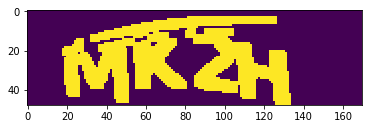

In [15]:
test = X_train[1727]
plt.imshow(test)

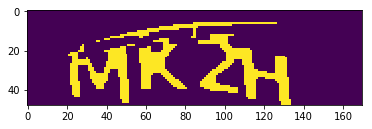

In [16]:
k1 = np.ones((2,2), np.uint8)
k2 = np.ones((1,1), np.uint8)
test = cv2.erode(test, k1, iterations=3)

plt.imshow(test)

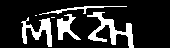

In [17]:
img = Image.fromarray(test)
img

In [18]:
def split_three_characters(img):
    tmp1 = drop_fall(img)
    if tmp1[0].shape[1] > tmp1[1].shape[1]:
        tmp2 = drop_fall(Image.fromarray(tmp1[0]))
        return [tmp2[0], tmp2[1], tmp1[1]]
    else:
        tmp2 = drop_fall(Image.fromarray(tmp1[1]))
        return [tmp1[0], tmp2[0], tmp2[1]]

In [19]:
def split_captcha(img):
    split_seq = get_split_seq(get_projection_x(img))
    print(split_seq)
    
    if(len(split_seq) == 1):
        print("有回歸線沒清乾淨")
        k1 = np.ones((2,2), np.uint8)
        tmp = np.array(img)
        tmp = cv2.erode(tmp, k1, iterations=1)
        split_seq = get_split_seq(get_projection_x(Image.fromarray(tmp)))
        print(split_seq)
        
    # 切割图片
    croped_images = []
    split_images = []
    height = img.size[1]

    for start_x, width in split_seq:
        # 同时去掉y轴上下多余的空白
        begin_row = 0
        end_row = height - 1
        for row in range(height):
            flag = True
            for col in range(start_x, start_x + width):
                if img.getpixel((col, row)) == 255:
                    flag = False
                    break
            if not flag: # 如果在当前行找到了黑色像素点，就是起始行
                begin_row = row
                break

        for row in reversed(range(height)):
            flag = True
            for col in range(start_x, start_x + width):
                if img.getpixel((col, row)) == 255:
                    flag = False
                    break
            if not flag:
                end_row = row
                break
        croped_images.append(img.crop((start_x, begin_row, start_x + width, end_row + 1)))

    c = len(croped_images)

    if len(croped_images) < 4:
        x = np.array(split_seq)
        idx = np.argmax(x[:, 1])
        
        if len(croped_images) == 3:
            tmp = drop_fall(croped_images[idx])
            split_images.append(tmp[0])
            split_images.append(tmp[1])
            
            del croped_images[idx]
            croped_images.insert(idx, Image.fromarray(tmp[0]))
            croped_images.insert(idx + 1, Image.fromarray(tmp[1]))

        elif len(croped_images) == 2:
            if x[idx][1] >= x[1-idx][1]*2:
                sub = split_three_characters(croped_images[idx])
                split_images = sub
                if idx == 0:
                    del croped_images[idx]
                    croped_images.insert(idx, Image.fromarray(sub[0]))
                    croped_images.insert(idx+1, Image.fromarray(sub[1]))
                    croped_images.insert(idx+2, Image.fromarray(sub[2]))
                else:
                    croped_images[1] = Image.fromarray(sub[0])
                    croped_images.append(Image.fromarray(sub[1]))
                    croped_images.append(Image.fromarray(sub[2]))
            else:
                tmp1 = drop_fall(croped_images[0])
                split_images.append(tmp1[0])
                split_images.append(tmp1[1])

                tmp2 = drop_fall(croped_images[1])
                split_images.append(tmp2[0])
                split_images.append(tmp2[1])

                croped_images[0] = Image.fromarray(split_images[0])
                croped_images[1] = Image.fromarray(split_images[1])
                croped_images.append(Image.fromarray(split_images[2]))
                croped_images.append(Image.fromarray(split_images[3]))
        else:
            tmp = np.array(croped_images[0])
            length = int(tmp.shape[1] / 4)
            croped_images[0] = Image.fromarray(tmp[:, 0:length])
            croped_images.append(Image.fromarray(tmp[:, length:2*length]))
            croped_images.append(Image.fromarray(tmp[:, 2*length:3*length]))
            croped_images.append(Image.fromarray(tmp[:, 3*length:tmp.shape[1]]))

    s = len(split_images)
    print("掃描分割後圖片數:", c)
    print("相連分割後圖片數:", s)
    
    if len(croped_images) > 4: 
        correct_idx = []
        for i in range(len(croped_images)):
            if croped_images[i].size[0] > 10 or croped_images[i].size[1] > 10:
                correct_idx.append(i)

        for i in range(len(correct_idx)):
            croped_images[i] = croped_images[correct_idx[i]]
    
    return croped_images

In [20]:
'''
one = []
five = []
six = []
seven = []
cnt = [0,0,0,0,0,0,0,0,0,0]

croped_images = split_captcha(img)
fig = plt.figure(figsize=(2, 2))
for i in range(4):
    fig.add_subplot(2, 2, i+1)
    out = croped_images[i].resize((48, 48))
    plt.imshow(out)
plt.show()
'''
preprocess_data = []
kernel = np.ones((2,2), np.uint8)
for i in range(X_train.shape[0]):
    print("Index:", i)
    img = Image.fromarray(cv2.erode(X_train[i], kernel, iterations=3))
    croped_images = split_captcha(img)
    print("總共圖片數:", len(croped_images))
    print("========================")
    for j in range(4):
        preprocess_data.append(np.array(croped_images[j].resize((48,48))))

Index: 0
[[23, 48], [73, 51]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 1
[[20, 19], [42, 21], [68, 20], [91, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2
[[20, 23], [51, 17], [70, 23], [98, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3
[[20, 18], [41, 23], [66, 20], [93, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4
[[20, 18], [42, 23], [72, 22], [96, 29]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5
[[21, 41], [68, 26], [96, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 6
[[23, 39], [69, 25], [98, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 7
[[22, 16], [41, 21], [64, 27], [92, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 8
[[20, 19], [47, 20], [70, 18], [91, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 9
[[20, 19], [40, 71]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 10
[[19, 22], [45, 20], [70, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 11
[[18, 24], [49, 21], [75, 19], [98, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 12
[[19, 22], [46, 21], [71, 26], [104, 18]]
掃描分割後圖片數: 4
相連分割後圖片數

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 94
[[23, 21], [47, 71]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 95
[[22, 22], [46, 44], [93, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 96
[[19, 19], [42, 19], [68, 26], [98, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 97
[[22, 64], [93, 17]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 98
[[18, 24], [47, 20], [71, 19], [92, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 99
[[23, 41], [67, 53]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 100
[[19, 19], [42, 22], [74, 20], [95, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 101
[[20, 23], [44, 77]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 102
[[22, 44], [77, 51]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 103
[[23, 38], [65, 26], [100, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 104
[[22, 44], [74, 19], [94, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 105
[[21, 18], [41, 84]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 106
[[20, 20], [41, 28], [70, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 107
[[17, 21], [45, 

[[23, 44], [68, 20], [97, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 197
[[20, 20], [45, 22], [68, 22], [97, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 198
[[20, 19], [46, 21], [68, 21], [92, 1], [96, 19]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 199
[[23, 64], [88, 23]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 200
[[21, 20], [43, 19], [66, 22], [94, 32]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 201
[[20, 20], [44, 19], [69, 24], [98, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 202
[[22, 40], [68, 25], [97, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 203
[[20, 22], [48, 22], [72, 2], [75, 19], [99, 28]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 204
[[20, 23], [48, 23], [75, 23], [104, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 205
[[21, 22], [47, 24], [77, 36]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 206
[[20, 22], [45, 19], [72, 16], [92, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 207
[[22, 21], [46, 22], [76, 49]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 208
[[22, 20], [44, 23], 

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 274
[[22, 17], [43, 48], [97, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 275
[[18, 19], [41, 19], [62, 16], [84, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 276
[[21, 18], [45, 37], [87, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 277
[[18, 1], [21, 18], [45, 17], [67, 36]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 278
[[19, 20], [44, 43], [93, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 279
[[17, 20], [46, 23], [72, 22], [99, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 280
[[20, 23], [49, 20], [74, 17], [95, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 281
[[20, 22], [48, 19], [72, 17], [92, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 282
[[18, 20], [45, 24], [70, 22], [99, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 283
[[19, 22], [47, 18], [69, 27], [100, 29]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 284
[[19, 22], [44, 27], [74, 24], [105, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 285
[[20, 19], [41, 3], [45, 75]]
掃描分割後圖片數: 3
相連分割後圖片數

掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 356
[[21, 42], [70, 20], [93, 29]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 357
[[21, 20], [42, 24], [71, 22], [99, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 358
[[21, 18], [41, 22], [71, 25], [98, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 359
[[21, 23], [50, 23], [76, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 360
[[21, 23], [49, 42], [102, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 361
[[22, 20], [45, 19], [70, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 362
[[22, 41], [69, 18], [92, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 363
[[20, 23], [48, 26], [81, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 364
[[22, 25], [49, 30], [81, 53]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 365
[[20, 22], [47, 26], [78, 18], [100, 34]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 366
[[20, 19], [43, 60], [104, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 367
[[22, 23], [49, 20], [72, 28], [107, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 368
[[20, 19], [

[[20, 20], [43, 23], [77, 25], [104, 30]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 457
[[21, 23], [47, 23], [76, 25], [106, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 458
[[22, 48], [81, 38]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 459
[[19, 21], [45, 23], [74, 33], [113, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 460
[[21, 23], [50, 37], [94, 28]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 461
[[21, 23], [49, 21], [74, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 462
[[22, 20], [44, 48], [101, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 463
[[20, 21], [42, 25], [74, 17], [96, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 464
[[19, 20], [42, 18], [65, 26], [96, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 465
[[19, 43], [67, 25], [99, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 466
[[23, 17], [44, 21], [68, 19], [90, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 467
[[20, 23], [50, 17], [70, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 468
[[24, 20], [46, 17], [66, 21], [93, 23]]
掃描分割後

Index: 551
[[20, 42], [70, 16], [91, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 552
[[19, 23], [45, 3], [50, 24], [78, 66]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 553
[[23, 21], [47, 22], [78, 23], [110, 6], [119, 5], [127, 4]]
掃描分割後圖片數: 6
相連分割後圖片數: 0
總共圖片數: 6
Index: 554
[[20, 23], [47, 21], [76, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 555
[[22, 43], [71, 20], [95, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 556
[[19, 22], [45, 22], [72, 16], [93, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 557
[[22, 41], [70, 38]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 558
[[19, 22], [46, 25], [76, 24], [109, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 559
[[18, 18], [39, 27], [76, 24], [103, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 560
[[21, 41], [68, 53]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 561
[[21, 46], [73, 26], [107, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 562
[[22, 18], [42, 1], [46, 19], [71, 21], [98, 27]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 563
[[21, 21], [47, 41

Index: 635
[[19, 17], [41, 39], [85, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 636
[[18, 15], [39, 17], [62, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 637
[[22, 49], [78, 22], [104, 27]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 638
[[18, 4], [23, 15], [44, 20], [73, 45]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 639
[[22, 42], [68, 36], [111, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 640
[[23, 16], [41, 20], [64, 35], [100, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 641
[[16, 16], [36, 21], [64, 15], [84, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 642
[[18, 21], [44, 23], [76, 23], [102, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 643
[[20, 19], [42, 25], [74, 17], [94, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 644
[[21, 4], [26, 37], [75, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 645
[[22, 1], [24, 17], [45, 25], [76, 24], [104, 20]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 646
[[18, 20], [43, 30], [83, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 647
[[21, 19], [44, 2

[[19, 25], [49, 20], [70, 27], [104, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 738
[[20, 22], [46, 21], [74, 22], [105, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 739
[[21, 23], [46, 23], [74, 20], [99, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 740
[[18, 23], [47, 19], [71, 27], [104, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 741
[[21, 23], [47, 19], [70, 26], [97, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 742
[[18, 24], [48, 21], [72, 21], [97, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 743
[[22, 95]]
有回歸線沒清乾淨
[[23, 46], [74, 20], [99, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 744
[[22, 18], [45, 23], [72, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 745
[[22, 18], [43, 24], [69, 24], [97, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 746
[[21, 47], [72, 21], [98, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 747
[[19, 17], [43, 18], [64, 18], [87, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 748
[[18, 24], [48, 23], [75, 18], [97, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 

掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 817
[[22, 44], [74, 22], [99, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 818
[[20, 21], [46, 32], [80, 16], [100, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 819
[[19, 20], [45, 32], [80, 20], [103, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 820
[[19, 19], [42, 33], [80, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 821
[[19, 21], [43, 34], [83, 19], [105, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 822
[[19, 16], [38, 56], [99, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 823
[[19, 19], [45, 21], [70, 23], [96, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 824
[[20, 42], [64, 18], [87, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 825
[[17, 21], [40, 1], [44, 1], [47, 75]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 826
[[19, 18], [44, 26], [72, 20], [94, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 827
[[20, 21], [49, 57], [113, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 828
[[20, 22], [46, 26], [77, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 917
[[21, 28], [55, 17], [74, 21], [100, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 918
[[20, 28], [54, 20], [77, 23], [104, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 919
[[21, 21], [47, 21], [71, 27], [102, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 920
[[20, 26], [50, 13], [64, 56]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 921
[[21, 28], [55, 41], [102, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 922
[[22, 19], [43, 20], [71, 23], [98, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 923
[[22, 28], [56, 21], [78, 25], [107, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 924
[[21, 99]]
有回歸線沒清乾淨
[[22, 20], [43, 76]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 925
[[21, 27], [52, 21], [74, 18], [97, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 926
[[21, 27], [52, 18], [77, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 927
[[20, 28], [51, 7], [59, 12], [76, 26], [107, 19]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 928
[[21, 20], [43, 20], [69, 48]]
掃描分割後

[[21, 26], [53, 31], [88, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 995
[[20, 27], [53, 51], [112, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 996
[[20, 18], [41, 19], [65, 17], [85, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 997
[[21, 28], [51, 30], [85, 20], [111, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 998
[[20, 27], [53, 50], [108, 14]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 999
[[20, 24], [48, 43], [95, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1000
[[20, 26], [53, 43], [102, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1001
[[20, 27], [50, 20], [76, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1002
[[21, 25], [50, 28], [83, 26], [115, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1003
[[20, 25], [49, 26], [81, 18], [103, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1004
[[20, 21], [47, 28], [77, 16], [104, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1005
[[21, 29], [56, 55], [120, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1006
[[21, 18], [46, 72]]
掃描分割後圖片數: 2
相連

掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1075
[[22, 17], [45, 73]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1076
[[20, 25], [51, 68]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1077
[[22, 17], [41, 21], [67, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1078
[[19, 26], [52, 23], [76, 18], [100, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1079
[[22, 44], [71, 27], [106, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1080
[[19, 26], [48, 19], [72, 22], [97, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1081
[[20, 26], [52, 18], [74, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1082
[[21, 46], [71, 20], [98, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1083
[[19, 23], [48, 38], [94, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1084
[[18, 17], [41, 73]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1085
[[20, 26], [53, 40], [97, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1086
[[21, 17], [44, 42], [91, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1087
[[20, 24], [51, 19], [77, 45]]
掃描分割後圖片數: 3
相連分割後圖片數

[[20, 25], [50, 15], [66, 4], [76, 19], [100, 16]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1177
[[20, 33], [56, 7], [72, 33], [107, 4], [112, 16]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1178
[[21, 25], [48, 26], [78, 25], [108, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1179
[[20, 26], [49, 18], [70, 2], [81, 25], [108, 17]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1180
[[21, 25], [49, 14], [73, 19], [98, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1181
[[19, 49], [77, 27], [107, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1182
[[20, 26], [47, 26], [78, 18], [102, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1183
[[19, 36], [56, 5], [65, 26], [98, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1184
[[20, 26], [50, 24], [80, 24], [107, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1185
[[18, 23], [43, 50], [101, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1186
[[22, 24], [47, 23], [79, 24], [107, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1187
[[20, 43], [74, 27], [104, 17]]
掃描分割後圖片

[[20, 16], [43, 44], [94, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1256
[[23, 65], [100, 20]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1257
[[24, 38], [65, 22], [92, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1258
[[21, 20], [46, 39], [88, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1259
[[19, 20], [45, 18], [66, 23], [93, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1260
[[18, 21], [43, 19], [70, 19], [95, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1261
[[19, 18], [43, 21], [68, 21], [93, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1262
[[20, 68], [93, 27]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1263
[[23, 66], [94, 20]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1264
[[22, 40], [68, 44]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 1265
[[19, 21], [46, 19], [69, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1266
[[22, 18], [42, 49], [97, 15]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1267
[[23, 37], [64, 33], [102, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1268
[[20, 42], [69, 20],

[[22, 41], [70, 27], [101, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1355
[[18, 47], [72, 20], [98, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1356
[[21, 19], [43, 86]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1357
[[22, 37], [66, 22], [90, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1358
[[20, 20], [47, 20], [74, 16], [93, 1], [95, 15]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1359
[[22, 42], [69, 18], [92, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1360
[[22, 18], [45, 18], [65, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1361
[[23, 19], [45, 18], [67, 22], [97, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1362
[[20, 19], [41, 24], [74, 28], [103, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1363
[[22, 19], [45, 19], [73, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1364
[[23, 45], [78, 20], [104, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1365
[[23, 35], [66, 42]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 1366
[[19, 15], [37, 22], [66, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
In

[[19, 28], [50, 34], [89, 27], [127, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1456
[[22, 51], [80, 25], [109, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1457
[[23, 42], [73, 24], [101, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1458
[[21, 119]]
有回歸線沒清乾淨
[[22, 6], [30, 75], [116, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1459
[[0, 4], [25, 31], [60, 11], [72, 27], [100, 29]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1460
[[21, 48], [71, 22], [102, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1461
[[18, 28], [54, 69]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1462
[[24, 45], [78, 35]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 1463
[[20, 28], [50, 21], [76, 31], [118, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1464
[[21, 108]]
有回歸線沒清乾淨
[[22, 101]]
掃描分割後圖片數: 1
相連分割後圖片數: 0
總共圖片數: 4
Index: 1465
[[19, 49], [72, 25], [101, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1466
[[23, 50], [75, 4], [83, 19], [103, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1467
[[18, 8], [29, 10], [47, 23], 

[[21, 27], [54, 20], [79, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1558
[[23, 26], [53, 20], [79, 19], [99, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1559
[[19, 25], [51, 5], [58, 12], [76, 18], [96, 16]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1560
[[19, 29], [61, 11], [76, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1561
[[21, 27], [49, 21], [80, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1562
[[18, 22], [46, 19], [70, 25], [100, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1563
[[22, 19], [43, 4], [49, 13], [69, 11], [88, 25]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1564
[[21, 25], [52, 20], [78, 19], [99, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1565
[[21, 25], [57, 17], [76, 23], [105, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1566
[[20, 20], [44, 22], [74, 19], [94, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1567
[[19, 27], [53, 19], [80, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1568
[[22, 26], [52, 22], [79, 27], [109, 35]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4

[[19, 25], [51, 17], [73, 25], [102, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1637
[[18, 23], [45, 51], [99, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1638
[[18, 22], [50, 40], [98, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1639
[[19, 27], [48, 2], [54, 63]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1640
[[20, 22], [45, 26], [77, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1641
[[19, 24], [50, 26], [77, 17], [103, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1642
[[19, 25], [51, 17], [72, 23], [101, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1643
[[21, 24], [51, 27], [82, 22], [106, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1644
[[19, 22], [48, 44], [97, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1645
[[19, 25], [51, 49], [107, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1646
[[21, 22], [44, 26], [78, 48]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1647
[[19, 16], [40, 77]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1648
[[18, 17], [43, 44], [100, 16]]
掃描分割後圖片數: 3
相連分割後圖片數: 

掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 1716
[[21, 34], [60, 20], [85, 27], [121, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1717
[[21, 57], [81, 27], [116, 15]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1718
[[22, 61], [93, 17], [119, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1719
[[21, 40], [65, 20], [89, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1720
[[19, 11], [31, 23], [57, 1], [61, 17], [81, 3], [86, 16], [103, 26]]
掃描分割後圖片數: 7
相連分割後圖片數: 0
總共圖片數: 7
Index: 1721
[[18, 31], [55, 25], [81, 26], [110, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1722
[[22, 32], [56, 19], [80, 19], [103, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1723
[[20, 7], [28, 13], [44, 19], [64, 27], [106, 19]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1724
[[18, 22], [46, 19], [72, 57]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1725
[[21, 21], [45, 19], [70, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1726
[[21, 63], [90, 26], [122, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1727
[[21, 113]]
有回歸線沒清乾淨
[[2

Index: 1816
[[21, 25], [49, 19], [73, 24], [101, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1817
[[19, 18], [39, 18], [65, 52]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1818
[[18, 14], [33, 15], [52, 17], [74, 47]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1819
[[22, 42], [69, 26], [96, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1820
[[18, 8], [28, 8], [42, 70]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1821
[[22, 24], [49, 38], [93, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1822
[[19, 29], [51, 19], [76, 21], [100, 29]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1823
[[20, 52], [79, 19], [100, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1824
[[17, 21], [45, 28], [79, 16], [98, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1825
[[19, 30], [56, 47], [109, 16]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1826
[[20, 37], [60, 27], [89, 27]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1827
[[20, 27], [48, 29], [86, 18], [108, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1828
[[17, 20], [42, 19], [6

Index: 1893
[[20, 27], [51, 61], [118, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1894
[[19, 19], [42, 21], [66, 24], [98, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1895
[[20, 18], [42, 67]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1896
[[23, 43], [71, 18], [93, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1897
[[20, 24], [49, 23], [75, 20], [100, 6], [107, 14]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 1898
[[21, 24], [49, 22], [76, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1899
[[21, 24], [48, 23], [74, 22], [104, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1900
[[20, 19], [43, 22], [71, 26], [99, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1901
[[18, 18], [41, 22], [68, 18], [91, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1902
[[22, 20], [46, 19], [68, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1903
[[22, 23], [50, 45], [99, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1904
[[23, 23], [48, 22], [75, 19], [98, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1905
[[19, 23], [4

[[22, 45], [71, 30], [106, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1972
[[21, 19], [42, 56], [101, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1973
[[20, 19], [40, 2], [44, 18], [67, 48]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1974
[[20, 23], [51, 23], [78, 27], [111, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1975
[[19, 24], [48, 18], [70, 20], [100, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1976
[[22, 74], [103, 23]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 1977
[[21, 18], [42, 23], [74, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1978
[[17, 23], [47, 26], [79, 18], [101, 15]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1979
[[19, 21], [43, 25], [72, 21], [101, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1980
[[19, 16], [40, 26], [70, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1981
[[19, 52], [76, 22], [101, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 1982
[[19, 22], [44, 18], [66, 21], [94, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 1983
[[18, 20], [44, 25], [72, 18], 

Index: 2069
[[20, 100]]
有回歸線沒清乾淨
[[21, 25], [48, 26], [75, 22], [104, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2070
[[18, 18], [42, 17], [60, 19], [89, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2071
[[19, 95]]
有回歸線沒清乾淨
[[20, 25], [48, 18], [71, 22], [101, 13]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2072
[[20, 43], [70, 21], [93, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2073
[[18, 25], [45, 18], [68, 17], [89, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2074
[[19, 27], [50, 25], [82, 19], [107, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2075
[[19, 26], [48, 26], [82, 52]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2076
[[18, 26], [47, 23], [78, 23], [108, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2077
[[20, 51], [82, 17], [101, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2078
[[18, 116]]
有回歸線沒清乾淨
[[19, 25], [51, 66], [119, 15]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2079
[[18, 111]]
有回歸線沒清乾淨
[[19, 24], [49, 33], [83, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2080
[[2

[[22, 25], [54, 42], [101, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2171
[[20, 21], [48, 17], [66, 27], [97, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2172
[[20, 27], [55, 38], [98, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2173
[[20, 27], [50, 22], [77, 19], [99, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2174
[[19, 27], [52, 22], [79, 29], [112, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2175
[[19, 27], [52, 21], [77, 28], [111, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2176
[[21, 24], [51, 38], [100, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2177
[[18, 24], [51, 16], [70, 41]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2178
[[19, 21], [49, 41], [93, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2179
[[18, 22], [47, 19], [72, 23], [100, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2180
[[22, 43], [69, 44]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 2181
[[23, 35], [65, 23], [92, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2182
[[24, 38], [66, 26], [94, 19]]
掃描分割後圖片數: 3


掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2248
[[20, 27], [54, 17], [73, 19], [102, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2249
[[21, 21], [48, 18], [72, 21], [103, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2250
[[19, 21], [48, 18], [69, 26], [98, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2251
[[17, 25], [50, 18], [70, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2252
[[18, 25], [48, 18], [73, 17], [94, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2253
[[18, 27], [52, 28], [83, 27], [118, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2254
[[23, 24], [50, 51], [110, 27]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2255
[[23, 51], [79, 24], [109, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2256
[[21, 20], [47, 24], [77, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2257
[[22, 25], [48, 21], [75, 19], [98, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2258
[[21, 26], [52, 26], [84, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2259
[[21, 24], [48, 19], [71, 28], [106, 17]]
掃描分割後圖片數: 4


掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2326
[[21, 21], [44, 17], [66, 21], [96, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2327
[[19, 20], [48, 24], [74, 21], [98, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2328
[[23, 103]]
有回歸線沒清乾淨
[[24, 102]]
掃描分割後圖片數: 1
相連分割後圖片數: 0
總共圖片數: 4
Index: 2329
[[18, 28], [54, 26], [85, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2330
[[19, 22], [49, 23], [76, 23], [105, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2331
[[20, 26], [51, 20], [72, 21], [98, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2332
[[21, 25], [48, 25], [77, 29], [110, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2333
[[21, 26], [52, 25], [79, 27], [113, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2334
[[18, 23], [49, 16], [67, 22], [93, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2335
[[22, 80], [108, 29]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2336
[[23, 23], [48, 50], [108, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2337
[[19, 25], [49, 20], [73, 49]]
掃描分割後圖片數: 3
相連分割後圖片數:

掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2409
[[15, 24], [48, 21], [72, 22], [97, 3], [103, 24]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2410
[[17, 15], [41, 78]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2411
[[15, 24], [45, 2], [52, 70]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2412
[[20, 26], [50, 20], [72, 28], [104, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2413
[[19, 26], [50, 20], [77, 25], [103, 5], [112, 12]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2414
[[25, 44], [76, 24], [107, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2415
[[16, 17], [46, 52], [99, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2416
[[15, 22], [49, 20], [70, 52]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2417
[[19, 19], [41, 29], [78, 32], [113, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2418
[[19, 12], [38, 24], [66, 24], [91, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2419
[[17, 25], [50, 28], [81, 26], [109, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2420
[[17, 19], [43, 19], [66, 22], [91, 18]]
掃描分割

[[16, 25], [47, 26], [81, 40]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2493
[[19, 20], [44, 1], [51, 25], [77, 4], [83, 40]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2494
[[18, 14], [37, 1], [44, 19], [66, 44]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2495
[[16, 19], [40, 1], [44, 2], [49, 1], [51, 82]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2496
[[25, 12], [44, 75]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2497
[[18, 20], [44, 23], [72, 17], [91, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2498
[[18, 46], [67, 19], [96, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2499
[[18, 25], [49, 26], [78, 27], [113, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2500
[[19, 2], [22, 23], [50, 23], [77, 21], [101, 19]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2501
[[18, 20], [48, 17], [70, 26], [99, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2502
[[19, 19], [43, 24], [73, 19], [95, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2503
[[20, 19], [46, 23], [75, 21], [99, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片

[[20, 25], [48, 1], [52, 28], [81, 22], [105, 25]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2572
[[17, 20], [47, 28], [80, 18], [102, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2573
[[15, 25], [54, 27], [82, 17], [108, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2574
[[20, 25], [53, 26], [83, 20], [107, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2575
[[18, 24], [53, 28], [86, 19], [109, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2576
[[18, 1], [21, 1], [23, 13], [42, 82]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2577
[[17, 9], [27, 113]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2578
[[17, 24], [53, 27], [83, 23], [112, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2579
[[22, 25], [53, 25], [82, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2580
[[22, 25], [53, 18], [74, 23], [104, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2581
[[19, 24], [51, 25], [82, 23], [109, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2582
[[20, 18], [47, 47], [100, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Inde

Index: 2673
[[17, 27], [48, 19], [72, 31], [115, 12]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2674
[[20, 18], [42, 24], [74, 27], [102, 7], [111, 17]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2675
[[18, 23], [50, 4], [58, 15], [79, 28], [111, 27]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2676
[[16, 25], [48, 26], [81, 26], [113, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2677
[[19, 25], [50, 25], [79, 12], [93, 4], [101, 24]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 2678
[[18, 20], [46, 20], [71, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2679
[[21, 23], [51, 22], [83, 17], [101, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2680
[[18, 25], [53, 23], [83, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2681
[[17, 22], [54, 17], [76, 33], [115, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2682
[[17, 25], [51, 23], [86, 23], [110, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2683
[[21, 44], [74, 19], [98, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2684
[[19, 21], [46, 17], [69, 42]]
掃描分割後

Index: 2776
[[17, 29], [51, 23], [78, 20], [101, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2777
[[22, 105]]
有回歸線沒清乾淨
[[23, 17], [44, 53], [101, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2778
[[17, 26], [48, 21], [74, 19], [96, 32]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2779
[[21, 46], [70, 34], [110, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2780
[[20, 23], [48, 73]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2781
[[20, 51], [76, 24], [101, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2782
[[22, 25], [51, 44], [101, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2783
[[21, 18], [42, 50], [99, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2784
[[20, 24], [49, 23], [76, 23], [102, 32]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2785
[[15, 24], [45, 20], [71, 25], [99, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2786
[[20, 22], [46, 40], [93, 27]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2787
[[18, 27], [46, 89]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2788
[[16, 23], [45, 27], [76, 50]

[[20, 26], [51, 16], [71, 21], [97, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2878
[[17, 18], [43, 38], [88, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2879
[[20, 25], [51, 18], [72, 50]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2880
[[22, 18], [45, 65]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2881
[[17, 21], [46, 59], [107, 16]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2882
[[22, 46], [73, 51]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 2883
[[23, 41], [70, 25], [98, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2884
[[21, 39], [65, 52]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 2885
[[21, 40], [67, 16], [88, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2886
[[21, 27], [51, 26], [87, 23], [118, 12]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2887
[[18, 21], [43, 27], [74, 20], [98, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2888
[[17, 28], [51, 25], [78, 24], [105, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2889
[[19, 25], [49, 19], [73, 19], [97, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
I

[[17, 20], [47, 18], [68, 22], [92, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2978
[[18, 20], [47, 25], [75, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2979
[[21, 22], [44, 27], [77, 17], [99, 15]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2980
[[23, 43], [71, 21], [97, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2981
[[19, 30], [54, 26], [86, 48]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2982
[[18, 17], [38, 24], [67, 25], [94, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2983
[[15, 22], [40, 1], [50, 26], [79, 45]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2984
[[20, 24], [48, 23], [75, 23], [103, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2985
[[18, 17], [43, 20], [68, 24], [95, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 2986
[[19, 25], [49, 70]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 2987
[[23, 42], [70, 25], [101, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2988
[[18, 18], [43, 47], [95, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 2989
[[21, 18], [43, 28], [72, 32], [106, 

[[20, 46], [68, 8], [78, 8], [89, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3079
[[22, 36], [68, 19], [91, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3080
[[20, 25], [50, 26], [83, 26], [116, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3081
[[18, 18], [43, 78]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3082
[[21, 22], [48, 73]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3083
[[22, 25], [48, 22], [74, 20], [99, 30]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3084
[[18, 22], [50, 77]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3085
[[21, 25], [50, 20], [74, 62]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3086
[[24, 50], [82, 16], [104, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3087
[[22, 49], [72, 17], [93, 3], [101, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3088
[[20, 27], [49, 21], [79, 26], [110, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3089
[[20, 18], [42, 33], [80, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3090
[[21, 21], [46, 23], [70, 22], [99, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共

Index: 3179
[[22, 26], [55, 46], [111, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3180
[[23, 17], [45, 80]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3181
[[20, 21], [44, 24], [75, 19], [97, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3182
[[18, 20], [42, 18], [73, 49]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3183
[[22, 24], [48, 17], [71, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3184
[[20, 23], [48, 21], [76, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3185
[[19, 21], [42, 25], [72, 20], [98, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3186
[[23, 55], [82, 23], [108, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3187
[[20, 23], [46, 13], [65, 7], [73, 14], [95, 23]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3188
[[19, 15], [38, 48], [92, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3189
[[18, 100]]
有回歸線沒清乾淨
[[19, 9], [29, 22], [56, 20], [81, 37]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3190
[[19, 24], [54, 67]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3191
[[22, 22], [45, 19], [68,

[[18, 25], [49, 62]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3275
[[18, 24], [50, 23], [75, 4], [82, 17], [108, 23]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3276
[[20, 24], [47, 26], [76, 21], [100, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3277
[[19, 24], [47, 20], [72, 22], [101, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3278
[[22, 18], [41, 37], [80, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3279
[[21, 18], [42, 17], [63, 14], [81, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3280
[[20, 26], [49, 24], [77, 19], [104, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3281
[[19, 26], [55, 21], [77, 1], [81, 21], [107, 18]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3282
[[21, 27], [52, 21], [79, 41]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3283
[[20, 25], [52, 25], [79, 17], [100, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3284
[[18, 21], [42, 26], [71, 56]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3285
[[21, 19], [42, 21], [69, 29], [100, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index

[[18, 30], [50, 17], [74, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3355
[[19, 14], [38, 21], [63, 15], [81, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3356
[[17, 18], [42, 21], [67, 25], [97, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3357
[[22, 26], [54, 18], [79, 19], [103, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3358
[[23, 45], [73, 20], [96, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3359
[[18, 23], [47, 14], [68, 26], [97, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3360
[[17, 25], [51, 27], [81, 25], [114, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3361
[[20, 8], [29, 10], [43, 21], [67, 25], [97, 32]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3362
[[19, 17], [42, 25], [72, 29], [108, 15]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3363
[[22, 20], [44, 21], [75, 20], [97, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3364
[[22, 43], [75, 22], [100, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3365
[[19, 22], [46, 36], [92, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3456
[[15, 23], [48, 61]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3457
[[22, 22], [45, 6], [53, 13], [70, 23], [98, 24]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3458
[[21, 23], [49, 21], [74, 21], [101, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3459
[[18, 54], [80, 45]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3460
[[19, 21], [47, 37], [92, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3461
[[20, 24], [52, 42], [102, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3462
[[19, 25], [49, 29], [82, 40]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3463
[[21, 19], [45, 24], [73, 37]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3464
[[21, 20], [45, 19], [65, 25], [96, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3465
[[21, 23], [54, 22], [79, 25], [108, 30]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3466
[[21, 53], [85, 50]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3467
[[19, 23], [44, 24], [75, 23], [103, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3468
[[21, 33],

Index: 3555
[[19, 26], [54, 19], [79, 26], [110, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3556
[[19, 17], [40, 30], [74, 24], [101, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3557
[[22, 21], [44, 26], [73, 27], [111, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3558
[[17, 26], [48, 16], [65, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3559
[[21, 17], [40, 39], [82, 16]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3560
[[22, 52], [75, 32], [112, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3561
[[23, 18], [44, 45], [91, 3], [95, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3562
[[21, 22], [50, 47], [102, 28]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3563
[[23, 41], [70, 42]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3564
[[21, 21], [44, 26], [77, 20], [104, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3565
[[21, 32], [57, 21], [86, 23], [111, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3566
[[20, 25], [51, 17], [70, 53]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3567
[[21, 39], [64, 20],

[[21, 20], [43, 22], [76, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3656
[[19, 25], [51, 25], [81, 23], [106, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3657
[[21, 25], [54, 26], [85, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3658
[[20, 18], [41, 4], [48, 9], [63, 19], [86, 27]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3659
[[24, 39], [69, 28], [99, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3660
[[21, 47], [77, 41]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3661
[[22, 23], [48, 17], [69, 27], [102, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3662
[[20, 28], [58, 20], [84, 18], [103, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3663
[[22, 52], [81, 39]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3664
[[21, 19], [46, 17], [65, 20], [86, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3665
[[21, 22], [46, 45], [100, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3666
[[22, 19], [42, 28], [73, 24], [100, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3667
[[23, 42], [71, 19], [95, 22]]
掃描分割

Index: 3752
[[19, 29], [53, 86]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3753
[[23, 19], [46, 49], [99, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3754
[[21, 19], [43, 19], [65, 26], [101, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3755
[[20, 20], [43, 18], [69, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3756
[[21, 42], [73, 23], [100, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3757
[[17, 19], [41, 29], [77, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3758
[[22, 24], [49, 19], [71, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3759
[[20, 51], [83, 28], [112, 28]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3760
[[21, 21], [45, 47], [96, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3761
[[22, 20], [46, 39], [92, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3762
[[20, 28], [54, 21], [81, 17], [102, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3763
[[21, 34], [61, 45], [110, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3764
[[19, 27], [54, 54], [111, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數

Index: 3851
[[22, 62], [89, 25], [115, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3852
[[16, 19], [44, 28], [77, 19], [101, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3853
[[20, 18], [45, 43], [93, 32]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3854
[[19, 22], [49, 52], [110, 31]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3855
[[19, 77], [100, 24]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3856
[[21, 23], [49, 48], [102, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3857
[[22, 42], [66, 20], [90, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3858
[[24, 42], [72, 42]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3859
[[20, 35], [58, 80]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 3860
[[21, 21], [46, 44], [96, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3861
[[25, 85]]
有回歸線沒清乾淨
[[26, 30], [60, 19], [86, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3862
[[22, 22], [48, 20], [75, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3863
[[23, 16], [43, 31], [75, 19], [97, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數:

Index: 3950
[[22, 19], [42, 33], [82, 26], [111, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3951
[[19, 9], [29, 12], [47, 17], [69, 21], [95, 24]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 3952
[[20, 20], [47, 24], [73, 22], [102, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3953
[[19, 21], [47, 22], [72, 39]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3954
[[20, 19], [45, 23], [74, 24], [103, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3955
[[21, 20], [47, 43], [99, 27]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3956
[[21, 22], [45, 71], [118, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3957
[[20, 27], [54, 19], [78, 19], [106, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3958
[[23, 21], [47, 28], [78, 2], [81, 40]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3959
[[22, 26], [52, 45], [98, 4], [108, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 3960
[[22, 38], [64, 46]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 3961
[[19, 23], [47, 23], [73, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 3962
[[1

Index: 4048
[[19, 26], [54, 19], [77, 19], [100, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4049
[[19, 16], [39, 20], [67, 19], [90, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4050
[[21, 19], [44, 29], [77, 29], [110, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4051
[[18, 23], [49, 21], [72, 21], [99, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4052
[[20, 18], [41, 54], [99, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4053
[[22, 61], [94, 18]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4054
[[17, 26], [44, 2], [50, 59]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4055
[[17, 19], [42, 32], [76, 14], [99, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4056
[[19, 19], [44, 29], [75, 20], [100, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4057
[[24, 47], [74, 46]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4058
[[18, 18], [38, 5], [51, 46], [103, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4059
[[19, 29], [51, 21], [77, 50]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4060
[[21, 36], [64, 18], [88

Index: 4149
[[17, 17], [38, 52], [94, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4150
[[17, 25], [48, 40], [94, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4151
[[20, 18], [41, 82]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4152
[[19, 22], [43, 26], [79, 24], [108, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4153
[[21, 18], [41, 23], [67, 4], [76, 16], [102, 18]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4154
[[22, 46], [80, 44]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4155
[[21, 17], [45, 43], [97, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4156
[[20, 25], [47, 2], [50, 18], [71, 19], [98, 18]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4157
[[17, 20], [50, 16], [67, 22], [92, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4158
[[19, 25], [50, 19], [73, 19], [100, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4159
[[19, 24], [51, 25], [78, 25], [106, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4160
[[21, 27], [49, 13], [71, 49]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4161
[[22, 21], [47

Index: 4248
[[18, 20], [43, 47], [93, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4249
[[21, 20], [43, 2], [46, 21], [73, 28], [106, 27]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4250
[[21, 22], [48, 22], [75, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4251
[[20, 18], [43, 19], [67, 26], [94, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4252
[[19, 22], [47, 20], [71, 22], [96, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4253
[[18, 5], [24, 18], [44, 5], [51, 69]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4254
[[19, 20], [48, 17], [67, 1], [69, 20], [94, 22]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4255
[[21, 34], [57, 27], [91, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4256
[[22, 39], [68, 17], [92, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4257
[[23, 43], [67, 23], [101, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4258
[[21, 28], [55, 36], [94, 29]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4259
[[20, 20], [47, 18], [69, 48]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4260
[[19, 25

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4350
[[18, 22], [50, 63]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4351
[[20, 63], [90, 26]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4352
[[20, 44], [68, 26], [95, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4353
[[21, 24], [49, 18], [70, 27], [102, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4354
[[18, 29], [52, 22], [79, 20], [106, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4355
[[22, 40], [70, 26], [97, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4356
[[23, 43], [70, 26], [104, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4357
[[20, 25], [48, 20], [69, 2], [72, 47]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4358
[[21, 17], [39, 4], [45, 64]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4359
[[19, 27], [52, 18], [74, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4360
[[22, 25], [48, 20], [71, 54]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4361
[[21, 24], [46, 1], [50, 25], [76, 1], [79, 20], [107, 20]]
掃描分割後圖片數: 6
相連分割後圖片數: 0
總共圖片數: 6
Index: 4362
[[2

[[19, 36], [63, 18], [83, 20], [105, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4443
[[22, 42], [66, 63]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4444
[[22, 75], [102, 20]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4445
[[22, 41], [64, 24], [97, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4446
[[19, 24], [50, 47], [102, 16]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4447
[[19, 30], [55, 3], [59, 14], [77, 22], [102, 17]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4448
[[21, 43], [69, 29], [103, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4449
[[22, 43], [72, 19], [95, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4450
[[19, 25], [47, 25], [75, 23], [103, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4451
[[18, 26], [53, 41], [108, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4452
[[20, 27], [55, 10], [66, 17], [88, 26], [117, 22]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4453
[[21, 18], [44, 28], [75, 23], [104, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4454
[[18, 29], [57, 25], [89, 20],

Index: 4540
[[20, 43], [70, 26], [103, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4541
[[16, 24], [47, 27], [77, 25], [109, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4542
[[19, 20], [45, 18], [67, 24], [94, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4543
[[22, 15], [44, 45], [93, 30]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4544
[[20, 22], [48, 21], [70, 26], [101, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4545
[[21, 18], [44, 50], [105, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4546
[[19, 31], [57, 46], [111, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4547
[[17, 17], [39, 18], [62, 23], [88, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4548
[[20, 21], [47, 54], [107, 33]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4549
[[21, 25], [50, 22], [75, 19], [100, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4550
[[17, 2], [24, 12], [41, 16], [59, 2], [62, 38]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4551
[[20, 27], [51, 23], [79, 18], [99, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Ind

掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4637
[[20, 23], [50, 39], [90, 31]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4638
[[20, 29], [53, 25], [83, 16], [101, 15]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4639
[[18, 17], [42, 20], [65, 62]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4640
[[20, 23], [44, 23], [75, 17], [95, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4641
[[21, 19], [46, 21], [73, 46]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4642
[[20, 20], [42, 26], [72, 38]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4643
[[18, 20], [43, 24], [73, 18], [96, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4644
[[18, 24], [49, 23], [78, 22], [105, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4645
[[23, 43], [72, 42]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4646
[[19, 21], [44, 49], [100, 28]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4647
[[21, 45], [69, 43]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4648
[[21, 21], [48, 78]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4649
[[20, 20], [48, 47], [102, 24]

[[18, 19], [43, 18], [67, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4738
[[20, 21], [44, 22], [72, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4739
[[21, 23], [48, 13], [66, 37], [105, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4740
[[23, 46], [72, 64]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4741
[[22, 25], [52, 76]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4742
[[21, 23], [47, 25], [78, 20], [101, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4743
[[20, 22], [49, 43], [96, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4744
[[21, 18], [44, 43], [90, 1], [96, 30]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4745
[[20, 18], [43, 18], [66, 24], [95, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4746
[[19, 20], [45, 23], [72, 23], [100, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4747
[[20, 20], [43, 23], [75, 51]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4748
[[24, 48], [78, 26], [107, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4749
[[21, 21], [46, 20], [70, 26], [100, 18]]
掃描分割後圖片數: 4
相

[[23, 23], [49, 20], [71, 17], [91, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4835
[[24, 44], [74, 26], [106, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4836
[[21, 27], [53, 43], [103, 25]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4837
[[21, 23], [48, 53], [107, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4838
[[18, 28], [52, 26], [84, 26], [117, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4839
[[22, 62], [85, 64]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4840
[[19, 29], [51, 24], [81, 23], [113, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4841
[[19, 23], [45, 74]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4842
[[22, 39], [65, 24], [93, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4843
[[20, 28], [53, 19], [79, 41]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4844
[[19, 20], [48, 26], [76, 27], [104, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4845
[[22, 24], [47, 82]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 4846
[[23, 23], [50, 25], [77, 20], [100, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數:

Index: 4929
[[22, 20], [45, 25], [75, 18], [98, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4930
[[20, 20], [44, 27], [77, 21], [103, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4931
[[20, 37], [62, 49]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4932
[[17, 19], [46, 20], [72, 24], [101, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4933
[[19, 23], [47, 23], [73, 3], [77, 23], [105, 21]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4934
[[21, 41], [66, 45]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 4935
[[20, 33], [60, 20], [83, 17], [103, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4936
[[18, 7], [27, 14], [45, 6], [53, 12], [70, 38]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 4937
[[22, 42], [68, 19], [93, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 4938
[[22, 23], [48, 22], [73, 28], [106, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 4939
[[20, 1], [22, 22], [48, 15], [73, 24], [101, 1], [103, 18]]
掃描分割後圖片數: 6
相連分割後圖片數: 0
總共圖片數: 6
Index: 4940
[[18, 23], [49, 26], [76, 41]]
掃描分割後圖片數: 3
相連分割後圖片

相連分割後圖片數: 0
總共圖片數: 4
Index: 5028
[[16, 21], [43, 38], [89, 26]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5029
[[20, 30], [52, 29], [82, 18], [103, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5030
[[20, 60], [81, 23], [113, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5031
[[21, 23], [48, 74]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5032
[[21, 20], [46, 22], [74, 50]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5033
[[20, 23], [46, 25], [77, 47]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5034
[[22, 45], [73, 21], [97, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5035
[[18, 27], [56, 68]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5036
[[21, 24], [46, 19], [71, 41]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5037
[[21, 20], [43, 21], [67, 59]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5038
[[18, 24], [46, 23], [72, 23], [102, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5039
[[18, 16], [38, 22], [67, 19], [90, 24]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5040
[[20, 23], [47, 22], [73, 27], [106, 17]]


相連分割後圖片數: 0
總共圖片數: 4
Index: 5125
[[19, 30], [53, 23], [78, 25], [109, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5126
[[22, 53], [85, 41]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 5127
[[23, 63], [92, 16]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5128
[[22, 43], [68, 26], [103, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5129
[[19, 27], [53, 21], [78, 27], [110, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5130
[[22, 21], [48, 62], [114, 27]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5131
[[22, 25], [50, 19], [71, 29], [106, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5132
[[22, 29], [52, 79]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5133
[[20, 24], [49, 44], [100, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5134
[[19, 19], [40, 25], [67, 15], [89, 15]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5135
[[19, 25], [49, 23], [77, 22], [104, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5136
[[16, 25], [51, 21], [74, 27], [105, 23]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5137
[[19, 24], [47, 2

Index: 5225
[[21, 18], [40, 25], [71, 25], [101, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5226
[[20, 24], [49, 48], [100, 23]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5227
[[20, 17], [41, 27], [71, 55]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5228
[[21, 23], [49, 73]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5229
[[23, 16], [40, 12], [53, 24], [83, 28], [115, 29]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 5230
[[22, 19], [45, 26], [76, 20], [105, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5231
[[20, 27], [51, 27], [79, 15], [104, 32]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5232
[[18, 17], [38, 21], [68, 45]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5233
[[22, 19], [42, 19], [66, 23], [94, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5234
[[19, 7], [27, 1], [29, 11], [46, 20], [69, 52]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 5235
[[18, 2], [21, 14], [42, 24], [73, 47]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5236
[[17, 19], [46, 43], [95, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index:

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5326
[[21, 34], [58, 26], [90, 20], [116, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5327
[[22, 47], [72, 43]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 5328
[[21, 40], [71, 43]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 5329
[[16, 26], [52, 25], [79, 53]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5330
[[18, 25], [49, 65]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5331
[[22, 22], [45, 64]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5332
[[22, 23], [48, 23], [76, 23], [100, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5333
[[21, 20], [46, 21], [69, 18], [92, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5334
[[18, 16], [39, 44], [89, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5335
[[22, 27], [54, 20], [77, 26], [106, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5336
[[20, 1], [22, 16], [45, 7], [54, 40], [101, 20]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 5337
[[16, 4], [21, 2], [24, 11], [43, 27], [78, 27], [111, 19]]
掃描分割後圖片數: 6
相連分割後圖片數: 0
總共圖片數: 6
Inde

[[23, 65], [93, 26]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5425
[[20, 19], [44, 18], [63, 23], [87, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5426
[[23, 45], [76, 39]]
掃描分割後圖片數: 2
相連分割後圖片數: 4
總共圖片數: 4
Index: 5427
[[20, 19], [42, 19], [68, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5428
[[18, 17], [41, 26], [72, 19], [95, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5429
[[24, 38], [73, 23], [101, 20]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5430
[[22, 21], [47, 15], [68, 21], [94, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5431
[[23, 45], [72, 21], [106, 21]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5432
[[23, 22], [46, 24], [78, 20], [102, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5433
[[21, 17], [42, 22], [70, 20], [92, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5434
[[18, 21], [46, 40], [91, 28]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5435
[[22, 45], [70, 25], [100, 19]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5436
[[20, 20], [45, 22], [70, 20], [98, 21]]
掃描分割後圖片數: 4
相

Index: 5503
[[18, 24], [47, 25], [75, 44]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5504
[[20, 17], [39, 74]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5505
[[19, 24], [48, 26], [77, 23], [102, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5506
[[20, 27], [49, 27], [82, 25], [109, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5507
[[20, 27], [52, 26], [84, 53]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5508
[[21, 98]]
有回歸線沒清乾淨
[[22, 25], [57, 12], [70, 24], [99, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5509
[[21, 44], [75, 26], [102, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5510
[[18, 23], [46, 47], [97, 24]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5511
[[19, 23], [49, 36], [91, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5512
[[18, 16], [37, 19], [60, 16], [81, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5513
[[20, 25], [50, 40], [103, 18]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5514
[[21, 24], [51, 19], [73, 21], [101, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5515
[[21, 16], 

掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5604
[[17, 18], [41, 17], [61, 24], [88, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5605
[[22, 23], [49, 15], [71, 18], [96, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5606
[[22, 26], [54, 76]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5607
[[23, 27], [54, 83]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5608
[[19, 28], [52, 19], [78, 36]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5609
[[21, 28], [55, 21], [84, 49]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5610
[[18, 28], [56, 20], [79, 33], [114, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5611
[[22, 26], [51, 29], [81, 23], [110, 28]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5612
[[20, 28], [49, 6], [56, 80]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5613
[[18, 25], [51, 28], [82, 43]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5614
[[21, 20], [45, 29], [77, 29], [108, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5615
[[22, 25], [54, 23], [78, 20], [102, 19]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5616


[[21, 18], [43, 25], [72, 17], [93, 22]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5704
[[18, 17], [42, 21], [66, 4], [72, 47]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5705
[[21, 23], [49, 24], [74, 25], [101, 20]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5706
[[20, 17], [40, 20], [65, 37]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5707
[[19, 27], [48, 21], [73, 18], [94, 21]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5708
[[19, 96]]
有回歸線沒清乾淨
[[20, 25], [48, 24], [73, 41]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5709
[[17, 27], [52, 20], [74, 25], [105, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5710
[[18, 25], [47, 16], [67, 18], [88, 25]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5711
[[20, 41], [65, 25], [97, 17]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5712
[[17, 25], [46, 65]]
掃描分割後圖片數: 2
相連分割後圖片數: 3
總共圖片數: 4
Index: 5713
[[18, 25], [49, 39], [92, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5714
[[20, 93]]
有回歸線沒清乾淨
[[21, 17], [42, 19], [67, 8], [76, 37]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4


Index: 5803
[[16, 22], [47, 26], [79, 24], [110, 16]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5804
[[20, 21], [48, 23], [75, 26], [105, 18]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5805
[[17, 2], [21, 22], [49, 58], [110, 26]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5806
[[19, 24], [53, 27], [82, 3], [89, 12], [108, 27]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 5807
[[21, 27], [51, 46], [99, 22]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5808
[[16, 20], [50, 19], [78, 42]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5809
[[18, 23], [49, 23], [81, 50]]
掃描分割後圖片數: 3
相連分割後圖片數: 2
總共圖片數: 4
Index: 5810
[[20, 19], [46, 26], [78, 20], [101, 17]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5811
[[22, 25], [53, 27], [84, 2], [88, 21], [118, 22]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 5812
[[22, 20], [46, 20], [69, 2], [73, 20], [100, 18]]
掃描分割後圖片數: 5
相連分割後圖片數: 0
總共圖片數: 5
Index: 5813
[[19, 26], [49, 22], [78, 20], [100, 27]]
掃描分割後圖片數: 4
相連分割後圖片數: 0
總共圖片數: 4
Index: 5814
[[20, 22], [50, 20], [71, 15], [92, 23

In [21]:
len(preprocess_data)

23352

In [22]:
np.save("preprocessed_data", np.array(preprocess_data))